<a href="https://colab.research.google.com/github/eromanrangel/Miscellaneous/blob/Notebooks/DL_11_VAE_Pokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import plot_model

In [ ]:
# Pokemons
# https://github.com/musicmilif/Pokemon-Generator
# https://www.kaggle.com/code/lukemonington/pokemon-images-autoencoder-and-gan-in-tensorflow/notebook

In [25]:
# Hyper-parameters
batch_size = 64
img_size = 128

# Part 1: Load data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def load_image(img_path):
  return resize(imread(img_path, as_gray=True), (img_size, img_size)).astype('float32')

In [6]:
# Load images from directory
BASEDIR = "/content/drive/MyDrive/DataSets/pokemon-png"

imgs_in_dir = os.listdir(BASEDIR)
X = np.array([load_image(os.path.join(BASEDIR, img)) for img in imgs_in_dir])
X = X.reshape((-1, img_size, img_size, 1))
print(X.shape)

(819, 128, 128, 1)


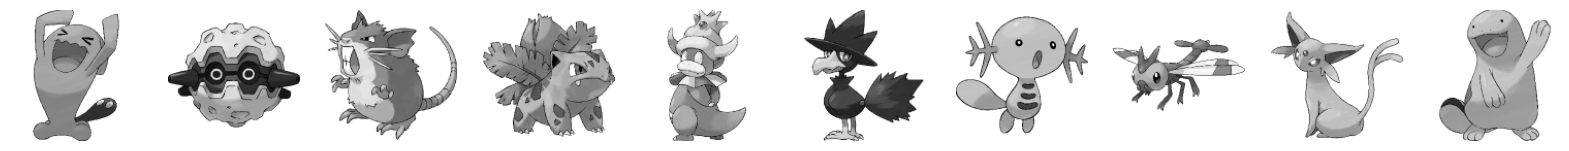

In [7]:
# Show a few examples
plt.figure(figsize=(20, 4))
for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.imshow(X[i], cmap='gray')
  plt.axis('off')
plt.show()

In [25]:
# Save images to disk in pickle format
np.save("pokemon-images.npy", X)

In [4]:
# reload pickle, if needed
X = np.load("pokemon-images.npy")

(819, 128, 128, 4)


# Part 2: Create Conv AE

In [30]:
# Define encoder
ConvAE = Sequential()

ConvAE.add(Input(shape=(img_size, img_size, 1), name='INPUT'))
ConvAE.add(Convolution2D(64, 3, padding='same', activation='relu'))
ConvAE.add(MaxPooling2D())
ConvAE.add(Convolution2D(128, 3, padding='same', activation='relu'))
ConvAE.add(MaxPooling2D())
ConvAE.add(Convolution2D(256, 3, padding='same', activation='relu'))
ConvAE.add(MaxPooling2D())
ConvAE.add(Convolution2D(512, 3, padding='same', activation='relu', name='LATENT'))

ConvAE.add(UpSampling2D())
ConvAE.add(Convolution2D(256, 3, padding='same', activation='relu'))
ConvAE.add(UpSampling2D())
ConvAE.add(Convolution2D(128, 3, padding='same', activation='relu'))
ConvAE.add(UpSampling2D())
ConvAE.add(Convolution2D(64, 3, padding='same', activation='relu'))
ConvAE.add(Convolution2D(1, 5, padding='same', activation='linear', name='OUTPUT'))

ConvAE.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 32, 32, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 32, 32, 256)       295168    
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 16, 16, 256)    

In [31]:
# Compile and train
ConvAE.compile(optimizer='adam', loss='mse')
history = ConvAE.fit(X, X, epochs=50, batch_size=batch_size, validation_split=0.1)

Epoch 1/50
24/24 [==============================] - 15s 257ms/step - loss: 0.2666 - val_loss: 0.0736
Epoch 2/50
24/24 [==============================] - 4s 156ms/step - loss: 0.0461 - val_loss: 0.0265
Epoch 3/50
24/24 [==============================] - 4s 154ms/step - loss: 0.0203 - val_loss: 0.0199
Epoch 4/50
24/24 [==============================] - 4s 155ms/step - loss: 0.0150 - val_loss: 0.0126
Epoch 5/50
24/24 [==============================] - 4s 158ms/step - loss: 0.0120 - val_loss: 0.0110
Epoch 6/50
24/24 [==============================] - 4s 159ms/step - loss: 0.0109 - val_loss: 0.0101
Epoch 7/50
24/24 [==============================] - 4s 159ms/step - loss: 0.0101 - val_loss: 0.0093
Epoch 8/50
24/24 [==============================] - 4s 160ms/step - loss: 0.0095 - val_loss: 0.0091
Epoch 9/50
24/24 [==============================] - 4s 161ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 10/50
24/24 [==============================] - 4s 162ms/step - loss: 0.0085 - val_loss: 0.008

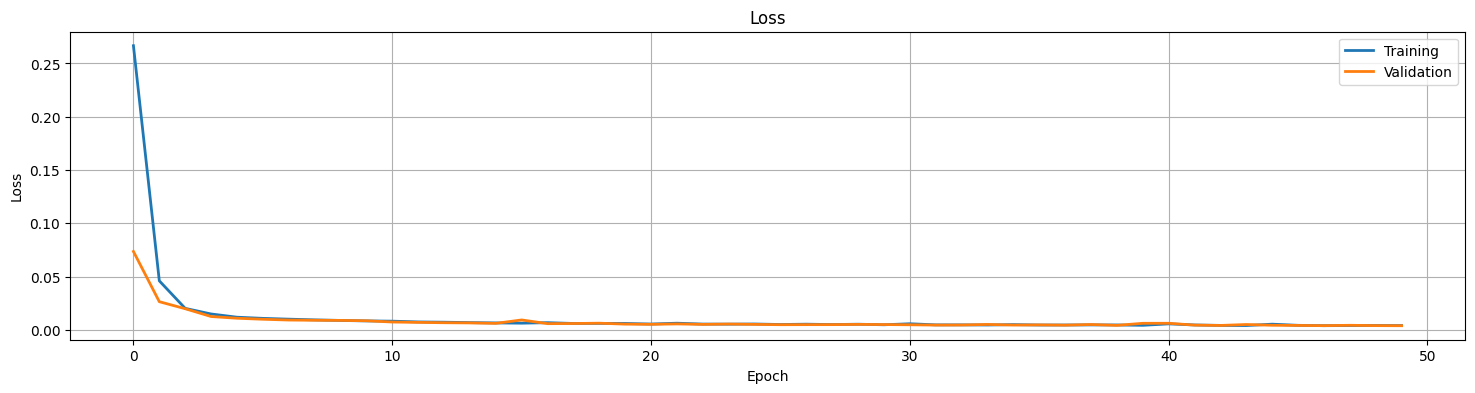

In [32]:
# Plot loss
plt.figure(figsize=(18, 4))
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

26/26 [==============================] - 2s 91ms/step
(819, 128, 128, 1)


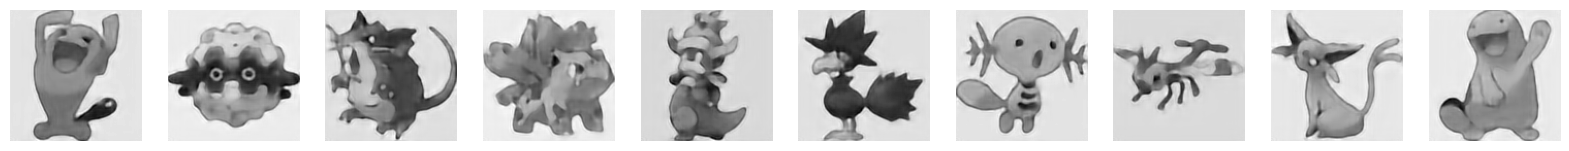

In [33]:
# See some examples of reconstruction
X_hat = ConvAE.predict(X)
print(X_hat.shape)

plt.figure(figsize=(20, 4))
for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.imshow(X_hat[i], cmap='gray')
  plt.axis('off')
plt.show()

In [34]:
# Save model
ConvAE.save("ConvAE-pokemons.h5")

# Part 3: See Latent Space

In [36]:
# Create encoder
ConvEncoder = Model(inputs=ConvAE.input, outputs=ConvAE.layers[6].output)

ConvEncoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_70 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 32, 32, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 32, 32, 256)       2951

(819, 16, 16, 512)


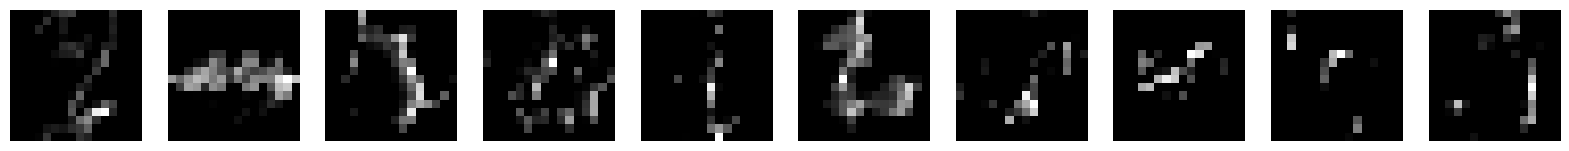

In [43]:
# Map to latent space
Z = ConvEncoder.predict(X)
print(Z.shape)

plt.figure(figsize=(20, 4))
for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.imshow(Z[i][:, :, 6], cmap='gray')
  plt.axis('off')
plt.show()

In [44]:
# Mat to vect
Z_vect = Z.reshape(len(Z), -1)
print(Z_vect.shape)

(819, 131072)


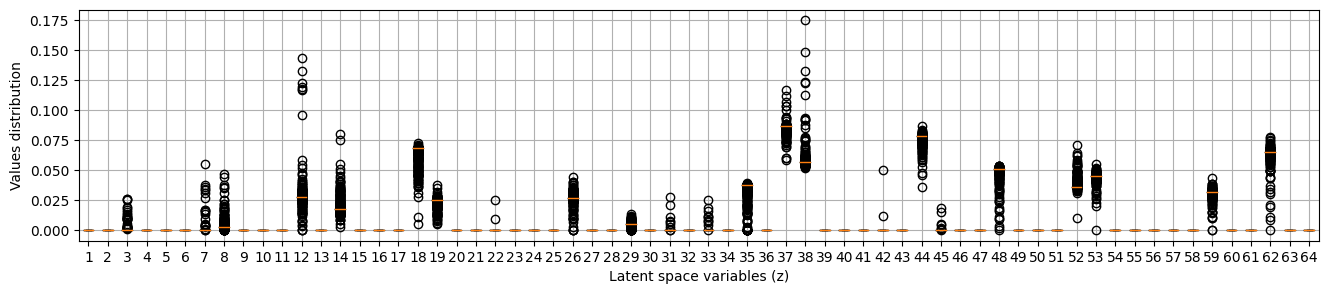

In [52]:
# Plot distribution of latent space
plt.figure(figsize=(16, 3))
plt.boxplot(Z_vect[:, :64])
plt.xlabel('Latent space variables (z)')
plt.ylabel('Values distribution')
plt.grid()
plt.show()

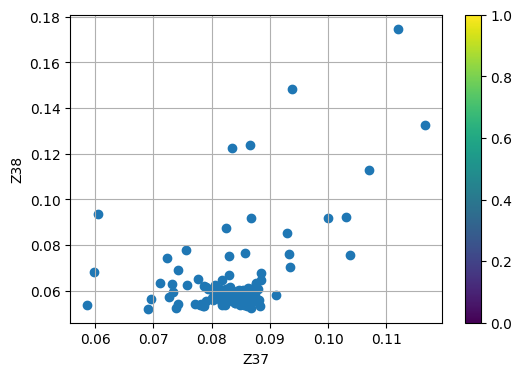

In [59]:
# Plot latent space in 2-D "regular AE"
plt.figure(figsize=(6, 4))
plt.scatter(Z_vect[:, 36], Z_vect[:, 37])
plt.colorbar()
plt.xlabel('Z37')
plt.ylabel('Z38')
plt.grid()
plt.show()

# Part 4 : Image reconstruction

In [62]:
# Define decoder
ConvDecoder = Sequential()
ConvDecoder.add(Input(shape=(16, 16, 512)))
for lay in ConvAE.layers[7:]:
  ConvDecoder.add(lay)

ConvDecoder.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_31 (UpSamplin  (None, 32, 32, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, 32, 32, 256)       1179904   
                                                                 
 up_sampling2d_32 (UpSamplin  (None, 64, 64, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_74 (Conv2D)          (None, 64, 64, 128)       295040    
                                                                 
 up_sampling2d_33 (UpSamplin  (None, 128, 128, 128)    0         
 g2D)                                                            
                                                     

26/26 [==============================] - 1s 46ms/step
(819, 128, 128, 1)


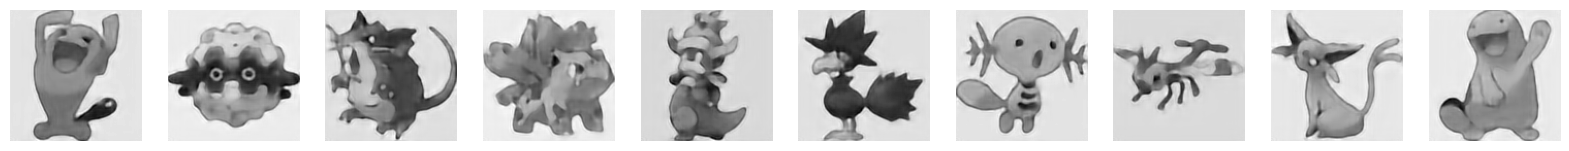

In [70]:
# Map to latent space
X_hat = ConvDecoder.predict(Z)
print(X_hat.shape)

plt.figure(figsize=(20, 4))
for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.imshow(X_hat[i], cmap='gray')
  plt.axis('off')
plt.show()

26/26 [==============================] - 1s 47ms/step
(819, 128, 128, 1)


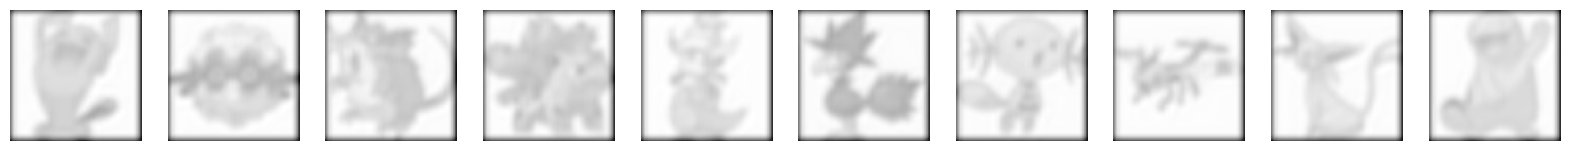

In [72]:
# Generate random points within the distribution of Z
X_hat = ConvDecoder.predict(Z + 0.05)
print(X_hat.shape)

plt.figure(figsize=(20, 4))
for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.imshow(X_hat[i], cmap='gray')
  plt.axis('off')
plt.show()

1/1 [==============================] - 0s 41ms/step


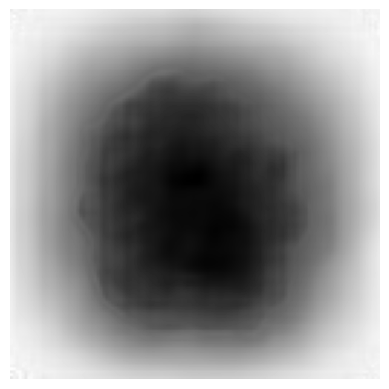

In [74]:
# Average pokemon
z_means = Z_vect.mean(axis=0).reshape(1, 16, 16, 512)
x_hat_samples = ConvDecoder.predict(z_means)

plt.imshow(x_hat_samples[0], cmap='gray')
plt.axis('off')
plt.show()

In [83]:
# Generate random points within the distribution of Z
z_means = Z_vect.mean(axis=0)

latent_len = 131072
z_samples = np.zeros((10, latent_len))
for z_ind in range(latent_len):
  z_samples[:, z_ind] = np.random.normal(loc=z_means[z_ind], scale=1, size=(10))

z_samples = z_samples.reshape((len(z_samples), 16, 16, 512))
print(z_samples.shape)

(10, 16, 16, 512)


1/1 [==============================] - 0s 25ms/step
(10, 128, 128, 1)


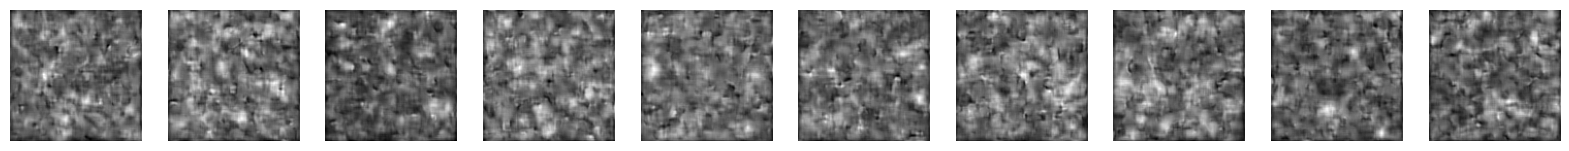

In [84]:
# Generate synthetic data
x_hat_samples = ConvDecoder.predict(z_samples)
print(x_hat_samples.shape)

# Show a few reconstruction from random samples
plt.figure(figsize=(20, 3))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_hat_samples[i], cmap='gray')
    plt.axis('off')
plt.show()